# ACA high background events correlation analysis

This notebook looks at the distribution of a few independent variables seen
during ACA high background events.

## Pitch

For pitch angle < ~160, the high background events
follow the mission pitch distribution. In other words, there is no correlation
between pitch angle and seeing a high background event. 

However, for pitch > ~160, the incidence of high background events is increased
by about an order of magnitude.

The very highest pitch seen in a high background event is 177.8, which happens
to be the somewhat unusual obsid 24983 for which the event spanned 1.5 hours and showed
persistent background variability with a period of about a minute. See [SS&AWG 2021x03x17](https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/StarWorkingGroupMeeting2021x03x17) for details.

## Time after maneuver

ACA high background events are biased toward times within the first 10% of the
observation duration, and the vast majority of events happen within the first
10 ksec.

## Distance from Earth center

There is clear correlation with distance from the Earth Center and the
frequency of ACA high background events, with events being more likely 
at low altitudes. This may simply be a consequence of the increased
frequency of tail-sun attitudes during rad zone.

The physical relevance is whether local gravity gradient forces play
a role in ACA high background events. Back of the envelope calculations
indicate that they might be relevant in this regime, though probably
at least an order of magnitude below the Solar pressure force.

There is a somewhat interesting feature that ACA high background events that
occur more than 10 ksec after the observation start seem to be at either
dist < 20000 km or dist > 120000 km, but not in between. This may be an
artifact of something else.

There does not appear to be any correlation between distance and Sun pitch
angle in high background events.


In [1]:
from astropy.table import Table
import astropy.units as u
from cxotime import CxoTime
from kadi.commands.states import get_states
from cheta import fetch
from kadi import events
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')
%matplotlib inline

In [2]:
url = 'https://cxc.cfa.harvard.edu/mta/ASPECT/aca_hi_bgd_mon/'

In [3]:
evts = Table.read(url, format='ascii.html')

In [4]:
evts['Date'] = CxoTime(evts['Date'])

In [5]:
pitch = fetch.Msid('pitch', '2000:001', stat='5min')

In [6]:
evt_pitches = []
evt_dts = []
evt_obs_times = []

for evt in evts:
    date = evt['Date']
    try:
        idx = np.searchsorted(pitch.times, date.secs)
        evt_pitches.append(pitch.vals[idx])
    except IndexError:
        # Handle events that are in events web page and kadi commands but 
        # not yet in cheta archive
        states = get_states(date, date + 10*u.s, state_keys=['pitch'])
        state = states[0]
        evt_pitches.append(state['pitch'])
        
    try:
        manvr = events.manvrs.filter(obsid=evt['Obsid'])[0]
        dt = date - CxoTime(manvr.kalman_start)
        obs_time = CxoTime(manvr.next_manvr_start) - CxoTime(manvr.kalman_start)
        evt_dts.append(dt.to_value(u.ks))
        evt_obs_times.append(obs_time.to_value(u.ks))
    except Exception as err:
        print(err)
        evt_dts.append(-10.0)
        evt_obs_times.append(10.0)

Error: Found 0 events matching obsid=46458


In [7]:
manvr = events.manvrs.filter(obsid=evts['Obsid'][10])[0]
manvr.kalman_start

'2021:035:22:42:19.356'

In [8]:
evts['pitch'] = evt_pitches
evts['dt'] = evt_dts
evts['obs_time'] = evt_obs_times
evts['pitch'].format = '.1f'
evts['dt'].format = '.1f'
evts['obs_time'].format = '.1f'

In [9]:
evts[np.abs(evts['dt']) < 0.01]

<Table length=15>
         Date         Obsid N events N Slots ...  pitch     dt   obs_time
        object        int64  int64    int64  ... float32 float64 float64 
--------------------- ----- -------- ------- ... ------- ------- --------
2020:129:10:57:09.146 47224        1       1 ...    99.4     0.0      9.1
2020:095:04:57:34.991 47329        1       4 ...   175.8     0.0      6.5
2019:269:19:23:24.522 47863        1       1 ...   168.7     0.0      2.1
2019:012:01:37:57.537 21252        1       1 ...    55.3     0.0      5.2
2016:168:00:48:27.304 50944        1       1 ...   154.4     0.0      4.2
2016:062:05:59:31.471 51214        2       1 ...    52.1     0.0      5.6
2013:047:03:35:14.387 15316        1       1 ...   144.6     0.0     39.2
2012:258:23:43:11.270 54325        1       1 ...   151.4     0.0      2.9
2007:343:01:25:20.188  9381        1       1 ...    59.0     0.0     30.2
2007:303:05:46:29.521  9744        1       1 ...    46.4     0.0      6.9
2007:303:03:47:57.046  9743        1       1 ...    46.4     0.0      6.8
2007:188:22:31:42.647 58323        1       1 ...   145.8     0.0     21.0
2007:062:13:15:23.050  7721        1       1 ...   144.6     0.0      7.2
2001:010:21:16:10.215  2414       13       1 ...    47.0     0.0      6.2
2001:010:19:25:32.314  2411        1       1 ...    47.0     0.0      6.3

In [10]:
def plot_dist(evts, pitch, start='2000:001', stop=None):
    start = CxoTime(start)
    stop = CxoTime(stop)

    # Filter evts and pitch by start:stop
    ok = (evts['Date'] >= start) & (evts['Date'] <= stop)
    evts = evts[ok]
    dur = (stop - start).jd / 365.25
    print(f'Events per year: {len(evts) / dur:.1f}')

    idx0, idx1 = np.searchsorted(pitch.times, [start.secs, stop.secs])
    pitch_vals = pitch.vals[idx0:idx1]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    weight = len(evts) / len(pitch_vals)
    weights = np.full(len(pitch_vals), fill_value=weight)
    vals_all, bins, _ = plt.hist(pitch_vals.clip(45, 180), bins=40, weights=weights,
                                label='Pitch distribution');

    vals_evt, bins, _ = plt.hist(evts['pitch'], bins=bins, alpha=0.5, 
                                 label=f'Hi bgd events {start.date[:8]} to {stop.date[:8]}');
    plt.legend()
    plt.title('Distribution of hi bgd events vs. Sun pitch')
    plt.ylabel('Number of events')
    plt.xlabel('Sun pitch angle (deg)');

    plt.subplot(1, 2, 2)
    bins_c = (bins[:-1] + bins[1:]) / 2
    plt.plot(bins_c, vals_evt / vals_all, '-o')
    plt.xlabel('Sun pitch angle (deg)')
    plt.title('Relative ratio of hi bgd events to pitch');

## Sun Pitch Angle

Events per year: 6.7


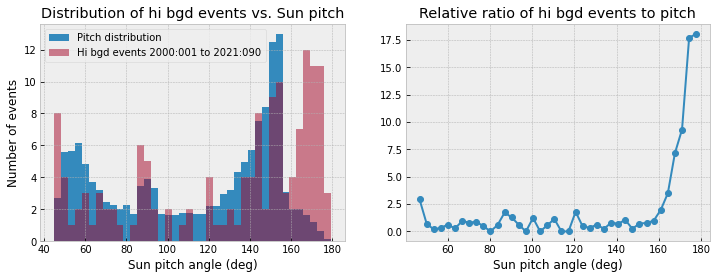

In [11]:
# Full mission
plot_dist(evts, pitch)

Events per year: 4.8


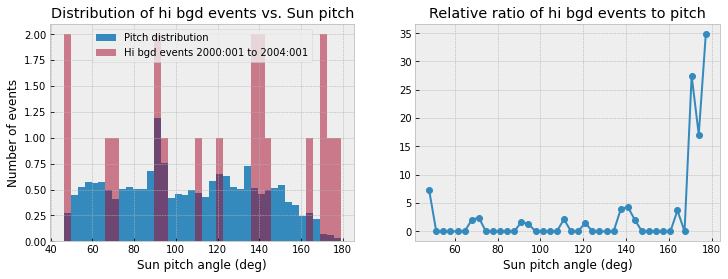

In [12]:
# Early mission
plot_dist(evts, pitch, start='2000:001', stop='2004:001')

Events per year: 2.9


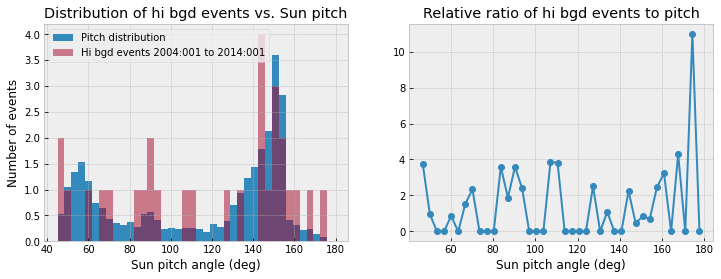

In [13]:
# Mid mission
plot_dist(evts, pitch, start='2004:001', stop='2014:001')

Events per year: 22.2


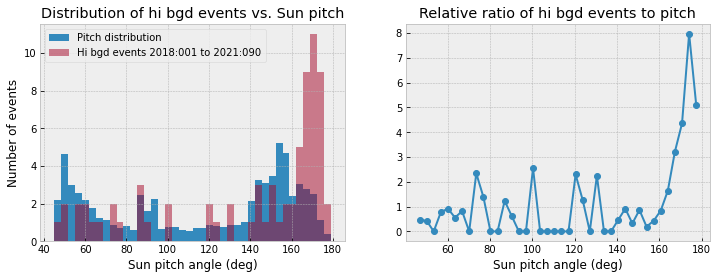

In [14]:
# Late mission
plot_dist(evts, pitch, start='2018:001')

## Time after end of maneuver

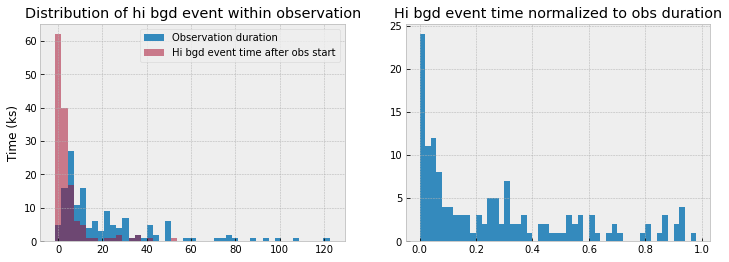

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
_, bins, vals = plt.hist(evts['obs_time'].clip(-15, None), bins=50, label='Observation duration');
plt.hist(evts['dt'].clip(-15, None), bins=bins, alpha=0.5, label='Hi bgd event time after obs start')
plt.legend()
plt.xlim(-8, None)
plt.title('Distribution of hi bgd event within observation')
plt.ylabel('Time (ks)');

plt.subplot(1, 2, 2)
plt.hist(evts['dt'].clip(-15, None) / evts['obs_time'], bins=np.arange(0, 1, 0.02));
plt.title('Hi bgd event time normalized to obs duration');

## Distance from Earth center

In [16]:
dist = fetch.Msid('Dist_SatEarth', '2000:001')

In [17]:
idx = np.searchsorted(dist.times, evts['Date'].secs)

In [18]:
evts['dist'] = dist.vals[idx] / 1000

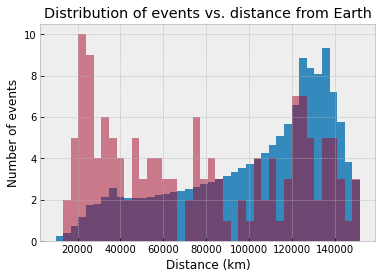

In [19]:
dist_vals = dist.vals / 1000
weight = len(evts) / len(dist_vals)
weights = np.full(len(dist_vals), fill_value=weight)
_, bins, _ = plt.hist(dist_vals, bins=40, weights=weights,
                      label='Distance distribution');

plt.hist(evts['dist'], bins=bins, alpha=0.5);
plt.title('Distribution of events vs. distance from Earth');
plt.xlabel('Distance (km)')
plt.ylabel('Number of events');



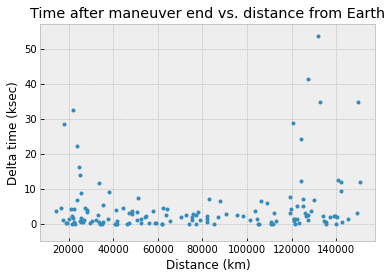

In [20]:
plt.plot(evts['dist'], evts['dt'].clip(-15, None), '.')
plt.ylim(-5, None)
plt.title('Time after maneuver end vs. distance from Earth')
plt.ylabel('Delta time (ksec)')
plt.xlabel('Distance (km)');

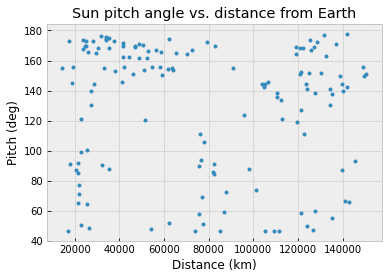

In [21]:
plt.plot(evts['dist'], evts['pitch'], '.');
plt.title('Sun pitch angle vs. distance from Earth')
plt.ylabel('Pitch (deg)')
plt.xlabel('Distance (km)');

## Extreme tail sun events

In [22]:
evts.sort('pitch')
evts[-5:]

<Table length=5>
         Date         Obsid N events ...    dt   obs_time        dist       
        object        int64  int64   ... float64 float64       float64      
--------------------- ----- -------- ... ------- -------- ------------------
2021:006:21:09:16.004 46666        1 ...     0.4      5.3 35320.344048949715
2020:095:04:57:34.991 47329        1 ...     0.0      6.5 34165.851069583245
2021:088:16:41:38.789 46458        1 ...   -10.0     10.0 31542.842931156465
2001:170:02:43:43.497   977        2 ...    53.6     61.5  131694.4965321634
2021:071:07:04:47.121 24983        7 ...     9.3     15.1 142154.20366552682